# Mixed Reversal + Momentum — Walk-Forward Validation

We validate an **equal-volatility mix** of cross-sectional **Reversal** (daily rebalance) and **Momentum** (monthly rebalance) on hourly crypto data using **expanding** and **rolling** walk-forward splits. We report out-of-sample (OOS) performance, **alpha/beta vs BTC**, and **cost sensitivity** at 7/10/20 bps.

In [1]:
# --- Core ---
import numpy as np
import pandas as pd
from pathlib import Path
from itertools import product
import matplotlib.pyplot as plt
import sys

# --- Display ---
pd.set_option("display.width", 160)
pd.set_option("display.max_columns", 200)

# --- Paths ---
PROJECT_ROOT = Path.cwd().parent          # .../crypto-stat-arb
SRC_DIR = PROJECT_ROOT / "src"            # .../crypto-stat-arb/src
PKG_DIR = SRC_DIR / "crypto_stat_arb"     # .../crypto-stat-arb/src/crypto_stat_arb
DATA_DIR = SRC_DIR / "data"               # .../crypto-stat-arb/src/data

# Make the package importable
if str(SRC_DIR) not in sys.path:
    sys.path.insert(0, str(SRC_DIR))

# --- Config ---
from crypto_stat_arb.config import ANNUALIZATION, COST_BPS, COST_RATE
from crypto_stat_arb.load import load_panels
from crypto_stat_arb.signals import cs_momentum_weights, cs_reversal_weights
from crypto_stat_arb.portfolio import downsample_weights
from crypto_stat_arb.backtest import backtest, perf_stats
from crypto_stat_arb.stats import rolling_sharpe, perf_summary_from_series_exact, compute_alpha_beta
from crypto_stat_arb.walkforward import run_walk_forward_mixed

print("PROJECT_ROOT:", PROJECT_ROOT)
print("SRC_DIR:", SRC_DIR)
print("PKG_DIR exists:", PKG_DIR.exists())
print("DATA_DIR:", DATA_DIR)
print("ANNUALIZATION:", ANNUALIZATION, "| COST_BPS:", COST_BPS, "| COST_RATE:", COST_RATE)

PROJECT_ROOT: C:\Users\Cameron Collins\crypto-stat-arb
SRC_DIR: C:\Users\Cameron Collins\crypto-stat-arb\src
PKG_DIR exists: True
DATA_DIR: C:\Users\Cameron Collins\crypto-stat-arb\src\data
ANNUALIZATION: 8760 | COST_BPS: 7 | COST_RATE: 0.0007


In [2]:
# Load price/return panels via helper
px, ret = load_panels(DATA_DIR)

print("Coverage window:", ret.index.min(), "→", ret.index.max(), f"({len(ret):,} bars)")
print("N assets:", ret.shape[1])
print("Max NA frac:", float(ret.isna().mean().max()))

if ret.isna().any().any():
    ret = ret.ffill().dropna(how="any")
    px  = px.loc[ret.index, ret.columns]
    print("After fill/drop:", ret.shape)

BENCH = "BTCUSDT" if "BTCUSDT" in ret.columns else None

Coverage window: 2023-01-01 01:00:00+00:00 → 2025-08-14 00:00:00+00:00 (22,944 bars)
N assets: 12
Max NA frac: 0.0


In [18]:
# --- Strategy params ---
params_rev = {"k": 4, "band": 2.5, "beta_win": 168, "vol_win": 24}
params_mom = {"k": 500, "band": 2.0, "beta_win": 168, "vol_win": None}
every_rev = 24
every_mom = 336  # used also as HAC lag baseline

# --- Benchmark series for alpha/beta ---
BENCH = "BTCUSDT" if "BTCUSDT" in ret.columns else None
bench_ret = ret[BENCH] if BENCH else ret.mean(axis=1)

Equal-Vol — per-fold mean Sharpe: Exp=2.574, Roll=2.575


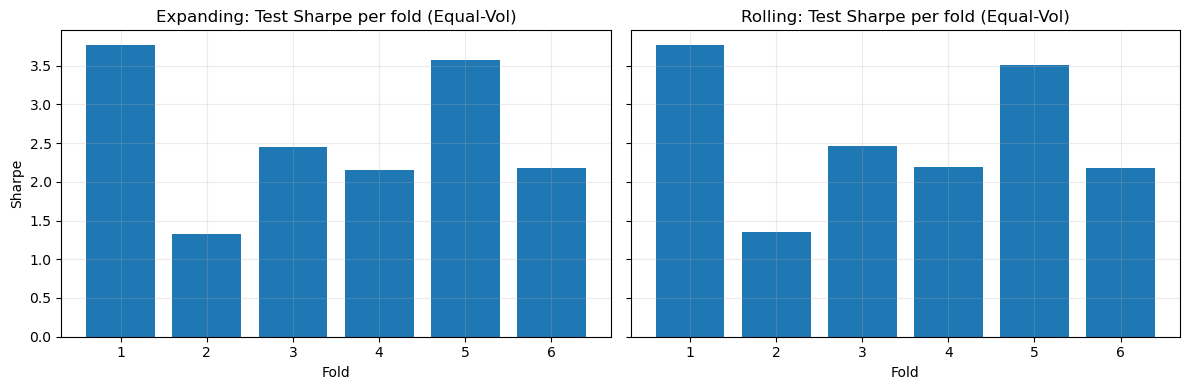

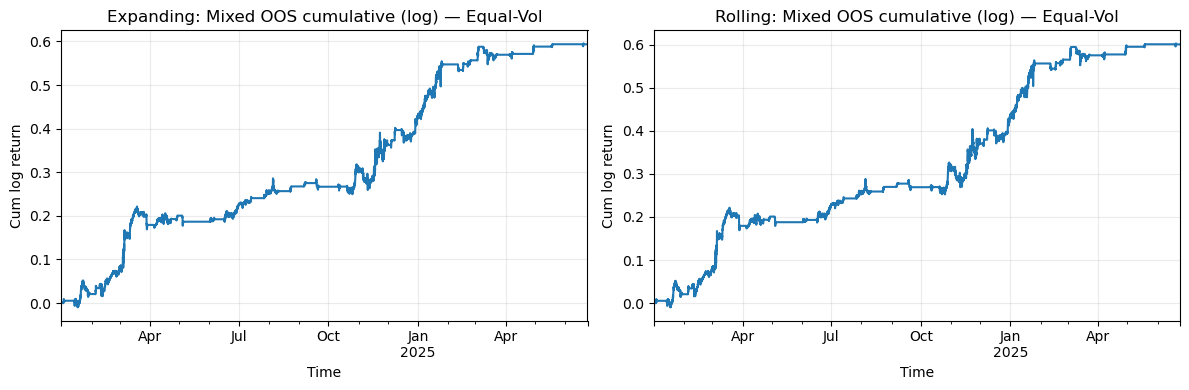

In [19]:
# === Equal-Vol walk-forward ===
eq_df_e, eq_oos_e = run_walk_forward_mixed(
    ret,
    params_rev, params_mom,
    every_rev=every_rev, every_mom=every_mom,
    mix_mode="equal_vol",
    train_days=365, test_days=90, mode="expanding",
    cost_bps=COST_BPS,
    reversal_func=cs_reversal_weights,
    momentum_func=cs_momentum_weights,
)
eq_df_r, eq_oos_r = run_walk_forward_mixed(
    ret,
    params_rev, params_mom,
    every_rev=every_rev, every_mom=every_mom,
    mix_mode="equal_vol",
    train_days=365, test_days=90, mode="rolling",
    cost_bps=COST_BPS,
    reversal_func=cs_reversal_weights,
    momentum_func=cs_momentum_weights,
)

print(
    "Equal-Vol — per-fold mean Sharpe:",
    f"Exp={eq_df_e['test_sharpe'].mean():.3f}, Roll={eq_df_r['test_sharpe'].mean():.3f}"
)

# Per-fold Sharpe bars
fig, ax = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
ax[0].bar(eq_df_e["fold"], eq_df_e["test_sharpe"]); ax[0].set_title("Expanding: Test Sharpe per fold (Equal-Vol)")
ax[0].set_xlabel("Fold"); ax[0].set_ylabel("Sharpe"); ax[0].grid(True, alpha=0.25)
ax[1].bar(eq_df_r["fold"], eq_df_r["test_sharpe"]); ax[1].set_title("Rolling: Test Sharpe per fold (Equal-Vol)")
ax[1].set_xlabel("Fold"); ax[1].grid(True, alpha=0.25)
plt.tight_layout(); plt.show()

# Stitched OOS cumulative (log cum for visualization only)
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
eq_oos_e.fillna(0).cumsum().plot(ax=ax[0]); ax[0].set_title("Expanding: Mixed OOS cumulative (log) — Equal-Vol")
ax[0].set_xlabel("Time"); ax[0].set_ylabel("Cum log return"); ax[0].grid(True, alpha=0.25)
eq_oos_r.fillna(0).cumsum().plot(ax=ax[1]); ax[1].set_title("Rolling: Mixed OOS cumulative (log) — Equal-Vol")
ax[1].set_xlabel("Time"); ax[1].set_ylabel("Cum log return"); ax[1].grid(True, alpha=0.25)
plt.tight_layout(); plt.show()

In [20]:
# === Train-Optimized walk-forward ===
OPT_GRID = np.linspace(0.0, 1.0, 51)

opt_df_e, opt_oos_e = run_walk_forward_mixed(
    ret,
    params_rev, params_mom,
    every_rev=every_rev, every_mom=every_mom,
    mix_mode="train_opt",
    opt_grid=OPT_GRID,
    train_days=365, test_days=90, mode="expanding",
    cost_bps=COST_BPS,
    reversal_func=cs_reversal_weights,
    momentum_func=cs_momentum_weights,
)
opt_df_r, opt_oos_r = run_walk_forward_mixed(
    ret,
    params_rev, params_mom,
    every_rev=every_rev, every_mom=every_mom,
    mix_mode="train_opt",
    opt_grid=OPT_GRID,
    train_days=365, test_days=90, mode="rolling",
    cost_bps=COST_BPS,
    reversal_func=cs_reversal_weights,
    momentum_func=cs_momentum_weights,
)

print(
    "Train-Opt — per-fold mean Sharpe:",
    f"Exp={opt_df_e['test_sharpe'].mean():.3f}, Roll={opt_df_r['test_sharpe'].mean():.3f}",
    "| mean w_mom:",
    f"Exp={opt_df_e['w_mom_mix'].mean():.3f}, Roll={opt_df_r['w_mom_mix'].mean():.3f}"
)

Train-Opt — per-fold mean Sharpe: Exp=2.213, Roll=2.144 | mean w_mom: Exp=0.397, Roll=0.507


In [21]:
# === Cost sensitivity (Equal-Vol) — per-fold mean vs concatenated OOS Sharpe ===
rows = []
for bps in [7, 10, 20]:
    # Expanding
    df_e, oos_e = run_walk_forward_mixed(
        ret, params_rev, params_mom,
        every_rev=every_rev, every_mom=every_mom,
        mix_mode="equal_vol",
        train_days=365, test_days=90, mode="expanding",
        cost_bps=bps,
        reversal_func=cs_reversal_weights,
        momentum_func=cs_momentum_weights,
    )
    # Rolling
    df_r, oos_r = run_walk_forward_mixed(
        ret, params_rev, params_mom,
        every_rev=every_rev, every_mom=every_mom,
        mix_mode="equal_vol",
        train_days=365, test_days=90, mode="rolling",
        cost_bps=bps,
        reversal_func=cs_reversal_weights,
        momentum_func=cs_momentum_weights,
    )

    # per-fold means
    fold_mean_e = float(df_e["test_sharpe"].mean())
    fold_mean_r = float(df_r["test_sharpe"].mean())

    # concatenated OOS Sharpe (simple returns; ANNUALIZATION should match your bar frequency)
    r_e = oos_e.dropna(); mu_e = r_e.mean() * ANNUALIZATION; sig_e = r_e.std(ddof=0) * (ANNUALIZATION ** 0.5)
    r_r = oos_r.dropna(); mu_r = r_r.mean() * ANNUALIZATION; sig_r = r_r.std(ddof=0) * (ANNUALIZATION ** 0.5)
    concat_e = (mu_e / sig_e) if (sig_e and sig_e != 0) else float("nan")
    concat_r = (mu_r / sig_r) if (sig_r and sig_r != 0) else float("nan")

    print(
        f"[Equal-Vol | {bps:>2} bps] "
        f"fold-mean S → Exp={fold_mean_e:.2f}, Roll={fold_mean_r:.2f} | "
        f"concat OOS S → Exp={concat_e:.2f}, Roll={concat_r:.2f}"
    )

    rows.append({
        "cost_bps": bps,
        "exp_fold_mean": round(fold_mean_e, 3),
        "roll_fold_mean": round(fold_mean_r, 3),
        "exp_concat_sharpe": round(concat_e, 3),
        "roll_concat_sharpe": round(concat_r, 3),
    })

cost_summary = pd.DataFrame(
    rows,
    columns=["cost_bps", "exp_fold_mean", "roll_fold_mean", "exp_concat_sharpe", "roll_concat_sharpe"]
)
display(cost_summary)

[Equal-Vol |  7 bps] fold-mean S → Exp=2.57, Roll=2.57 | concat OOS S → Exp=2.52, Roll=2.52
[Equal-Vol | 10 bps] fold-mean S → Exp=2.47, Roll=2.47 | concat OOS S → Exp=2.43, Roll=2.43
[Equal-Vol | 20 bps] fold-mean S → Exp=2.11, Roll=2.12 | concat OOS S → Exp=2.13, Roll=2.14


,cost_bps,exp_fold_mean,roll_fold_mean,exp_concat_sharpe,roll_concat_sharpe
0,7,2.574,2.575,2.518,2.519
1,10,2.467,2.470,2.428,2.432
2,20,2.106,2.120,2.128,2.141


,ann_ret,ann_vol,sharpe
Expanding — Equal-Vol,0.401,0.159,2.518
Rolling — Equal-Vol,0.406,0.161,2.518


,ann_ret,ann_vol,sharpe
Expanding — Train-Opt,0.362,0.181,1.999
Rolling — Train-Opt,0.377,0.196,1.928


Saved: C:\Users\Cameron Collins\crypto-stat-arb\figs\mixed_oos_pnl_equal_vol.png


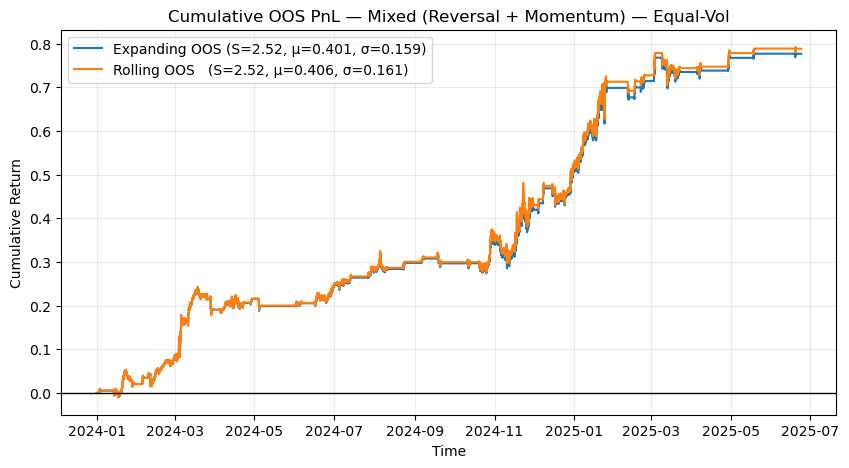

Saved: C:\Users\Cameron Collins\crypto-stat-arb\figs\mixed_oos_pnl_train_opt.png


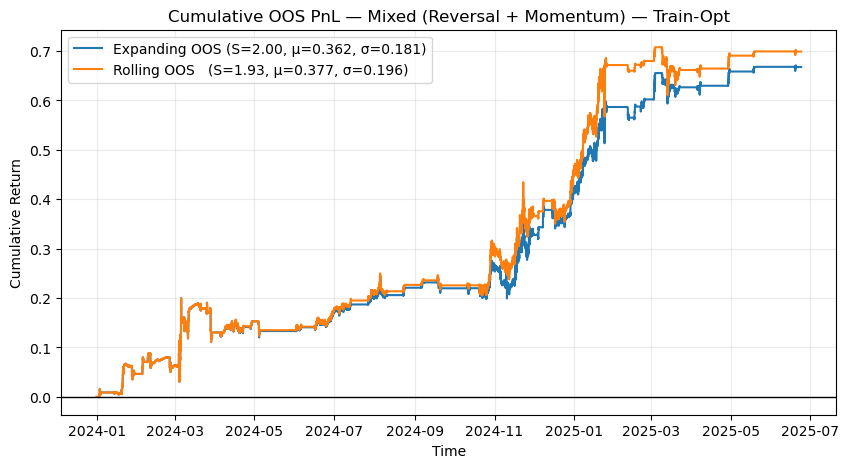

In [22]:
# === Concatenated OOS stats (ann_ret, ann_vol, sharpe) and figures ===

# Equal-Vol concatenated OOS stats
summary_eq = pd.DataFrame({
    "Expanding — Equal-Vol": perf_stats(eq_oos_e.dropna()),
    "Rolling — Equal-Vol":   perf_stats(eq_oos_r.dropna()),
}).T

# Train-Opt concatenated OOS stats
summary_opt = pd.DataFrame({
    "Expanding — Train-Opt": perf_stats(opt_oos_e.dropna()),
    "Rolling — Train-Opt":   perf_stats(opt_oos_r.dropna()),
}).T

display(summary_eq.round(3))
display(summary_opt.round(3))

# Plots (two figures) saved to figs/
figs = PROJECT_ROOT / "figs"
figs.mkdir(parents=True, exist_ok=True)

# Equal-Vol figure
stats_e = perf_stats(eq_oos_e.dropna()); stats_r = perf_stats(eq_oos_r.dropna())
lab_e = f"Expanding OOS (S={stats_e['sharpe']:.2f}, μ={stats_e['ann_ret']:.3f}, σ={stats_e['ann_vol']:.3f})"
lab_r = f"Rolling OOS   (S={stats_r['sharpe']:.2f}, μ={stats_r['ann_ret']:.3f}, σ={stats_r['ann_vol']:.3f})"
cum_e = (1 + eq_oos_e.dropna()).cumprod() - 1
cum_r = (1 + eq_oos_r.dropna()).cumprod() - 1

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(cum_e.index, cum_e.values, label=lab_e)
ax.plot(cum_r.index, cum_r.values, label=lab_r)
ax.axhline(0, color="black", lw=1)
ax.set_title("Cumulative OOS PnL — Mixed (Reversal + Momentum) — Equal-Vol")
ax.set_ylabel("Cumulative Return"); ax.set_xlabel("Time")
ax.legend(); ax.grid(True, alpha=0.25)
fig.savefig(figs / "mixed_oos_pnl_equal_vol.png", dpi=180, bbox_inches="tight")
print("Saved:", figs / "mixed_oos_pnl_equal_vol.png")
plt.show()

# Train-Opt figure
stats_e = perf_stats(opt_oos_e.dropna()); stats_r = perf_stats(opt_oos_r.dropna())
lab_e = f"Expanding OOS (S={stats_e['sharpe']:.2f}, μ={stats_e['ann_ret']:.3f}, σ={stats_e['ann_vol']:.3f})"
lab_r = f"Rolling OOS   (S={stats_r['sharpe']:.2f}, μ={stats_r['ann_ret']:.3f}, σ={stats_r['ann_vol']:.3f})"
cum_e = (1 + opt_oos_e.dropna()).cumprod() - 1
cum_r = (1 + opt_oos_r.dropna()).cumprod() - 1

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(cum_e.index, cum_e.values, label=lab_e)
ax.plot(cum_r.index, cum_r.values, label=lab_r)
ax.axhline(0, color="black", lw=1)
ax.set_title("Cumulative OOS PnL — Mixed (Reversal + Momentum) — Train-Opt")
ax.set_ylabel("Cumulative Return"); ax.set_xlabel("Time")
ax.legend(); ax.grid(True, alpha=0.25)
fig.savefig(figs / "mixed_oos_pnl_train_opt.png", dpi=180, bbox_inches="tight")
print("Saved:", figs / "mixed_oos_pnl_train_opt.png")
plt.show()

In [27]:
# === Alpha/Beta on stitched OOS (Equal-Vol) ===
series_map_eq = {
    "Expanding OOS — Equal-Vol": eq_oos_e,
    "Rolling OOS — Equal-Vol":   eq_oos_r,
}
hac_lag_eq = max(24, int(every_mom))

rows_eq = []
for label, r in series_map_eq.items():
    res = compute_alpha_beta(r, bench_ret, freq=ANNUALIZATION, lag_bars=hac_lag_eq)
    res["label"] = label
    rows_eq.append(res)

alpha_beta_eq = pd.DataFrame(rows_eq).set_index("label").round(3)
display(alpha_beta_eq)

# === Alpha/Beta on stitched OOS (Train-Opt) ===
series_map_opt = {
    "Expanding OOS — Train-Opt": opt_oos_e,
    "Rolling OOS — Train-Opt":   opt_oos_r,
}
hac_lag_opt = max(24, int(every_mom))

rows_opt = []
for label, r in series_map_opt.items():
    res = compute_alpha_beta(r, bench_ret, freq=ANNUALIZATION, lag_bars=hac_lag_opt)
    res["label"] = label
    rows_opt.append(res)

alpha_beta_opt = pd.DataFrame(rows_opt).set_index("label").round(3)
display(alpha_beta_opt)

,alpha_ann,alpha_t,beta,beta_t,R2,n_obs
label,,,,,,
Expanding OOS — Equal-Vol,0.416,3.557,-0.024,-3.008,0.006,12960
Rolling OOS — Equal-Vol,0.421,3.563,-0.024,-2.940,0.006,12960


,alpha_ann,alpha_t,beta,beta_t,R2,n_obs
label,,,,,,
Expanding OOS — Train-Opt,0.380,3.216,-0.029,-2.222,0.007,12960
Rolling OOS — Train-Opt,0.395,3.031,-0.028,-2.052,0.005,12960


## Results & Interpretation (Mixed Strategy)

### OOS performance — **train-optimized mix** (stitched, net of costs)
- **Expanding:** **Sharpe 2.00**, ann. ret **0.362**, ann. vol **0.181**
- **Rolling:**   **Sharpe 1.93**, ann. ret **0.377**, ann. vol **0.196**

*Cross-fold (per-fold) summary for train-optimized weights:*  
Expanding — mean Sharpe **2.213** (median **2.132**), mean **w_mom ≈ 0.40**  
Rolling — mean Sharpe **2.144** (median **2.184**), mean **w_mom ≈ 0.51**

### Alpha/Beta vs BTC (HAC / Newey–West)
Using **12,960 hourly obs**:
- **Expanding OOS:** **αₐₙₙ = 0.380**, **t(α) = 3.216**; **β = −0.029**, **t(β) = −2.222**; **R² = 0.007**.
- **Rolling OOS:**   **αₐₙₙ = 0.395**, **t(α) = 3.031**; **β = −0.028**, **t(β) = −2.052**; **R² = 0.005**.

**Interpretation:** Alpha is **positive and statistically significant** in both splits; beta is **small and negative**, with **near-zero R²**, indicating returns largely **orthogonal to BTC**.

### Cost sensitivity — **equal-vol mix** (for reference)
- **7 bps:**  Exp **2.57**, Roll **2.57**  
- **10 bps:** Exp **2.47**, Roll **2.47**  
- **20 bps:** Exp **2.11**, Roll **2.12**

*(Equal-vol remains very cost-resilient; train-optimized mix uses per-fold Sharpe on TRAIN and shows slightly lower stitched OOS Sharpe, consistent with shorter train windows and weight variability.)*

### Takeaways
- The mixed sleeve delivers **strong OOS Sharpe** with **significant alpha vs BTC** and minimal benchmark dependence.  
- **Train-optimized weights** center around **40–50% momentum** and perform well; the **equal-vol** blend remains a **robust baseline** with especially strong cost robustness.